In [28]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Material parameters and other general definitions

In [29]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha = 0               # editalo
alpha_Low_YIG = 1e-4    # Gilbert damping (-)
alpha_High_YIG = 1e12   # Gilbert damping (-)

Ms_YIG = 1.407e5            # Saturation magnetisation (A/m)

A_YIG = 4.22e-12           # Exchange stiffness (J/m)

## Sample and mesh cell creation

In [30]:
# Geometry [nm]
t = 60e-9
w = 500e-9
l = 60e-6

# self absorbing boundary condition
band = 1e-6

sourceWidth=600e-9 #cercare bene la misura sul righello
sourcePos=-l/4 #almeno iniettiamo le waves nel bulk, possiamo modificare

# Mesh cell [nm]
cx = 10e-9
cy = w
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx_0 = 550 * Oe
Hy_0 = 0*Oe
Hz_0 = 0

H_DC = (Hx_0, Hy_0, Hz_0)  # Zeeman field

# Amplitude of RF exiting field
H_RF_val= 10 * Oe

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization

## Transverse field definition

In [31]:
transverseFieldSize = 0.5e-6
Hy  = 0 * Oe
def Hspace_DC(point):
    x, y, z = point
    if (-transverseFieldSize/2 < x < transverseFieldSize/2 and -w/2 < y < w/2 and 0 < z < t):
        return (0, Hy, 0)
    else:
        return (0, 0, 0)
    


## Energy and boundary condition definition

In [32]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driverc


## Time simulation parameter definition

In [33]:
T = 300e-9 #100e-9
f_MAX = 4e9

f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling

ftype="sinc" 

## System definition

In [34]:
sysName=f"P3_{int(T*1e9)}ns_{int(f_MAX*1e-9)}GHz_{int(Hy/Oe)}Oe_{ftype}"
print(sysName)

P3_300ns_4GHz_0Oe_sinc


In [35]:
system = mm.System(name=sysName)
region = df.Region(p1=(-l/2, -w/2, 0), p2=(l/2, w/2, t))
mesh = df.Mesh(region=region, cell=cell)

# Field definition
Hy_Field = df.Field(mesh, nvdim=3, value=Hspace_DC)

def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_Low_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_Low_YIG)

    else:
        return (alpha_Low_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)

## System initialization

In [36]:
# macro to return correct saturation magnetisation inside or outside the sample
def Ms_value(pos):
    # from 0, only inside the sample
    x, y, z = pos

    if (-l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)
#WE ARE WORKING IN A 1D MESH, so we will not see any magnetization along y regardless unelss we make the mesh 2D

In [37]:
#WE ARE WORKING IN A 1D MESH, so we will not see any magnetization along y regardless unelss we make the mesh 2D
def plotM(system,axis):
    
    if axis=="x":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_x$')
        """
            system.m accesses the megnetization
            m.x accesses the x component
            x.sel("z") means "sliced at a fixed value of z", by defaut the middle of the system
            from mpl.scalar on it's just about putting the red/blue color code on the right
            """
        system.m.x.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
        """
            this basically just shows the vaues of the vector field m, as colored dots/arrows. 
            Uses the matplotlib.quiver method
            for low fields you only see yellow dots since the equilibrium magnetization is parallel to z
            """
    elif axis=="y":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_y$')
        system.m.y.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
    elif axis=="z":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_z$')
        system.m.z.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

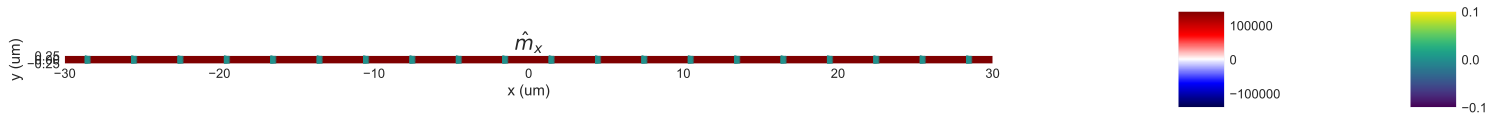

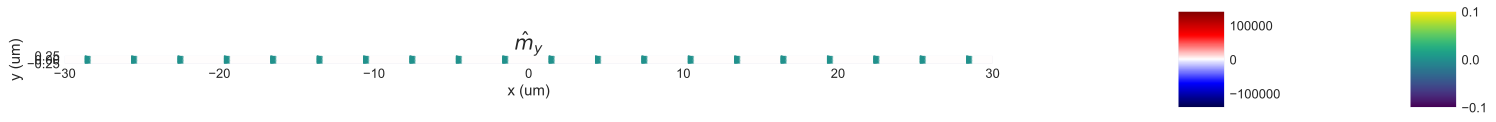

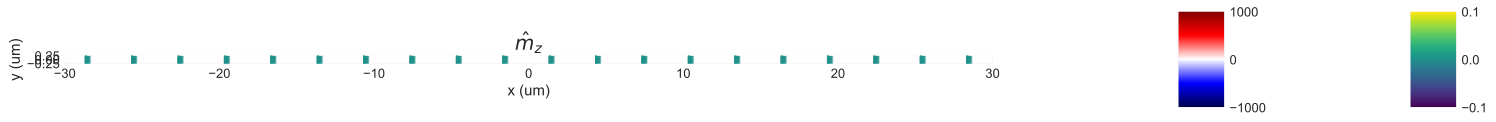

In [38]:
plotM(system,"x")
plotM(system,"y")
plotM(system,"z")
      

## Drive to equilibrium state

In [39]:
# get system to equilibrium

H_transverse = df.Field(mesh, nvdim=3, value=Hspace_DC)
zemTransverse=mm.Zeeman(H=H_transverse, name='transverse')
system.energy = dem + ex + zem +zemTransverse
mn.drive(system)

damping = mm.Damping(alpha=alpha)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/02/10 17:21]... (6.0 s)


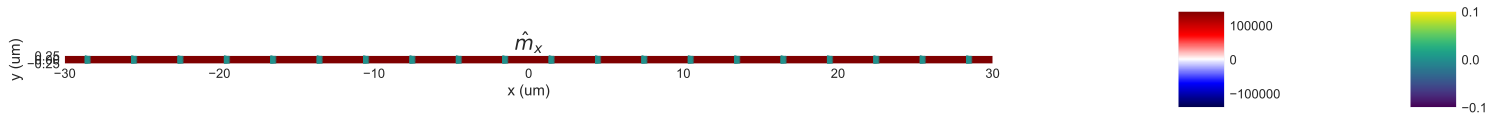

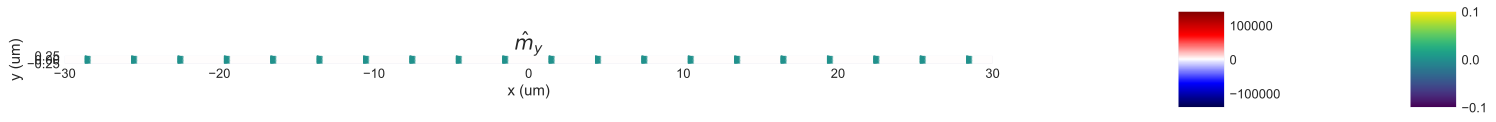

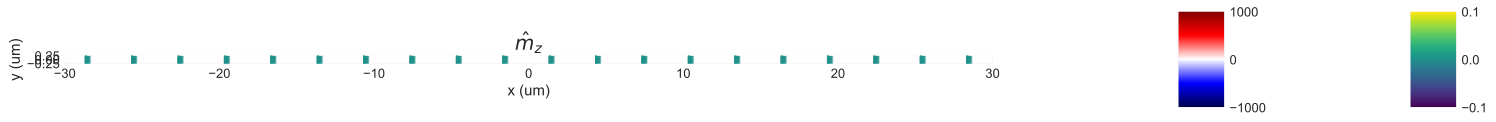

In [40]:
plotM(system,"x")
plotM(system,"y")
plotM(system,"z")

## RF injection

In [41]:
def Hspace_RF(point):
    x, y, z = point
    if (sourcePos-sourceWidth/2< x < sourcePos+sourceWidth/2 and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, H_RF_val)
    else:
        return (0,0,0)



H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func=ftype, f=f_MAX, t0=T/sampling, name='RF')
try:
    system.energy += zemRF
finally:
    td.drive(system, t=T, n=sampling, n_threads=19, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/2450 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2024/02/10 17:21] took 578.0 s


In [42]:
data = md.Data(sysName)
array = data[-1].to_xarray()
data_np = np.array(array)

mx = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 0]
my = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 1]
mz = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 2]



In [43]:
# from celluloid import Camera
# fig, ax = plt.subplots(figsize=(20, 5))
# camera = Camera(fig)

# for i in range(sampling): 
    
#     data[-1][i].y.sel('z').mpl.scalar(ax=ax,cmap='seismic',interpolation='bilinear',
#     colorbar=False,vmin=-10,vmax=10,multiplier=1e-9,
#     )
#     camera.snap()
    
    
# animation=camera.animate()
# filename='SW.gif'
# animation.save(filename,writer='Pillow',fps=5)

In [44]:
Ax = np.reshape(mx, (-1, round(l/cx-2*band/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(l/cx-2*band/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(l/cx-2*band/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

In [45]:
import matplotlib.colors as colors
import os
directory="images"
parentDir=f"{sysName}"
path=os.path.join(parentDir,directory)
if not os.path.isdir(path):
    os.mkdir(path)

# Show the intensity plot of the 2D FFT
def plotDispersion(m_fft,xbounds,ybounds,dim,extraDesc=""):
    #mx
    plt.figure(figsize=(10, 10))

    extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
    plt.imshow(np.log(np.abs(m_fft)**2), extent=extent,
           aspect='auto', origin='lower', norm=colors.CenteredNorm(vcenter=22), cmap="inferno")
    plt.ylabel("$f$ (Hz)")
    plt.xlabel("$kx$ (1/m)")
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    if dim=="x":
        plt.title('F(mx)')
        plt.savefig(f'{sysName}/images/F(mx)_'+extraDesc+".png", bbox_inches='tight')
    elif dim=="y":
        plt.title('F(my)')
        plt.savefig(f'{sysName}/images/F(my)_'+extraDesc+".png", bbox_inches='tight')
    if dim=="z":
        plt.title('F(mz)')
        plt.savefig(f'{sysName}/images/F(mz)_'+extraDesc+".png", bbox_inches='tight')

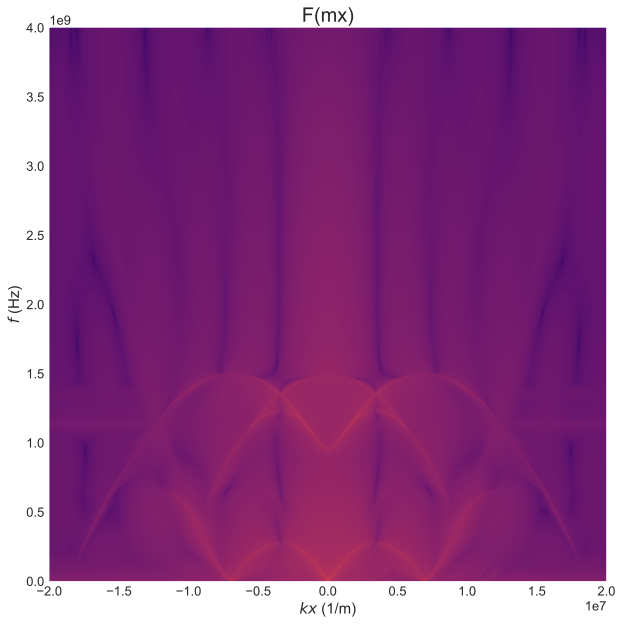

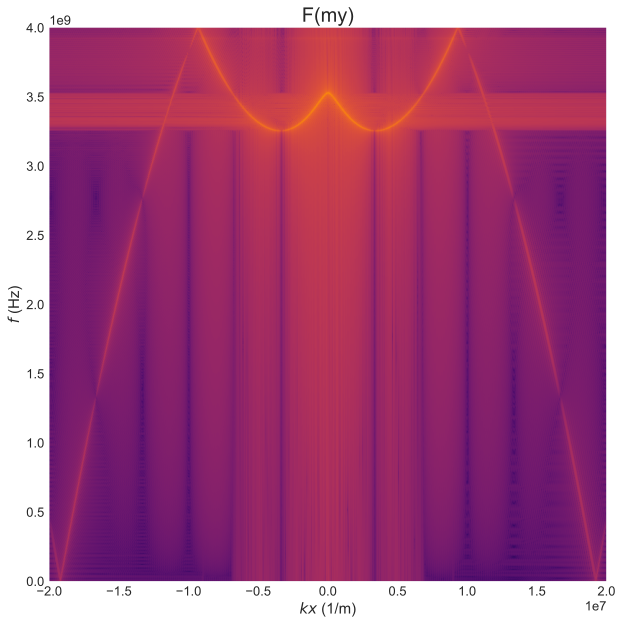

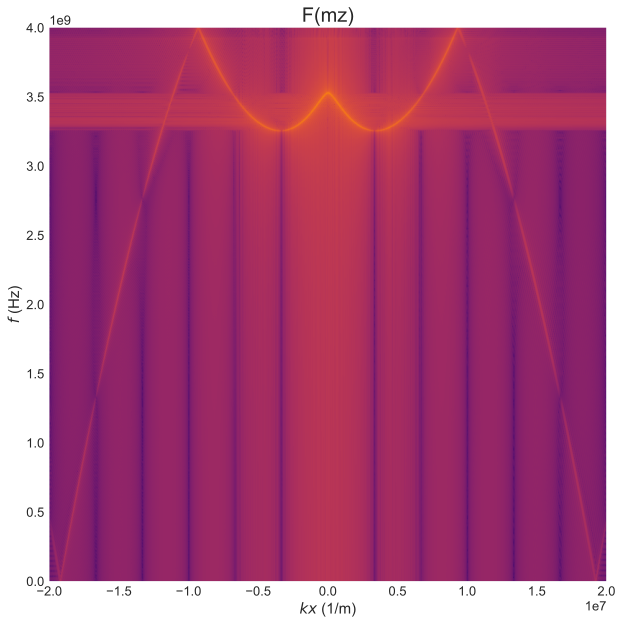

In [46]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x')
plotDispersion(m_fft_y,xbounds,ybounds,'y')
plotDispersion(m_fft_z,xbounds,ybounds,'z')

### Save simulation parameters in params.txt file

In [47]:
### Save simulation parameters in params.txt file
#import os
#cwd = os.getcwd()

with open(f"{sysName}/params.txt",'w') as f:
    if cy==w and cz==t:
        f.write(f"cell=({cx},w,t)\n")
    elif cy==w:
        f.write(f"cell=({cx},w,{cz})\n")
    elif cz==t:
        f.write(f"cell=({cx},{cy},t)\n")
    else:
        f.write(f"cell=({cx},{cy},{cz})")
    f.write("\n")
    f.write("Bias field:\n")
    f.write(f"Hx={Hx_0/Oe}Oe\n")
    f.write(f"Hy={Hz_0/Oe}Oe\n")
    f.write(f"Hz={Hz_0/Oe}Oe\n")
    f.write("\n")
    f.write("Barrier field:\n")
    f.write(f"H={Hy/Oe}Oe\n")
    f.write("\n")
    f.write("Exitation field:\n")
    f.write(f"Amplitude={H_RF_val}\n")
    f.write(f"f_MAX={f_MAX}\n")

## Reflectance
Analisys over the firt half of the sample

In [48]:
data = md.Data(sysName)
array = data[-1].to_xarray()
data_np = np.array(array)
buffer=transverseFieldSize/10

mx = data_np[:, round((band)/cx):round((l/2-transverseFieldSize/2-buffer/2)/cx), 0, 0, 0]
my = data_np[:, round((band)/cx):round((l/2-transverseFieldSize/2-buffer/2)/cx), 0, 0, 1]
mz = data_np[:, round((band)/cx):round((l/2-transverseFieldSize/2-buffer/2)/cx), 0, 0, 2]


In [49]:
halfsize=round((l/2-transverseFieldSize/2-buffer/2)/cx)-round((band)/cx)
print(halfsize)
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, halfsize))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1,halfsize))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, halfsize))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

2872


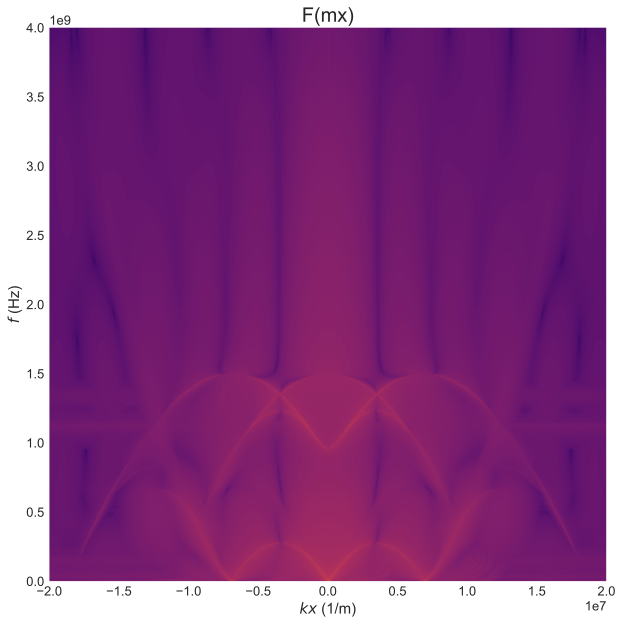

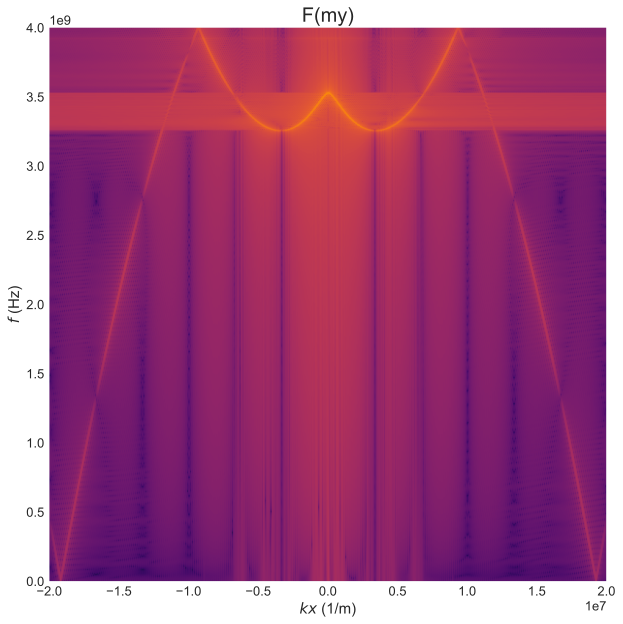

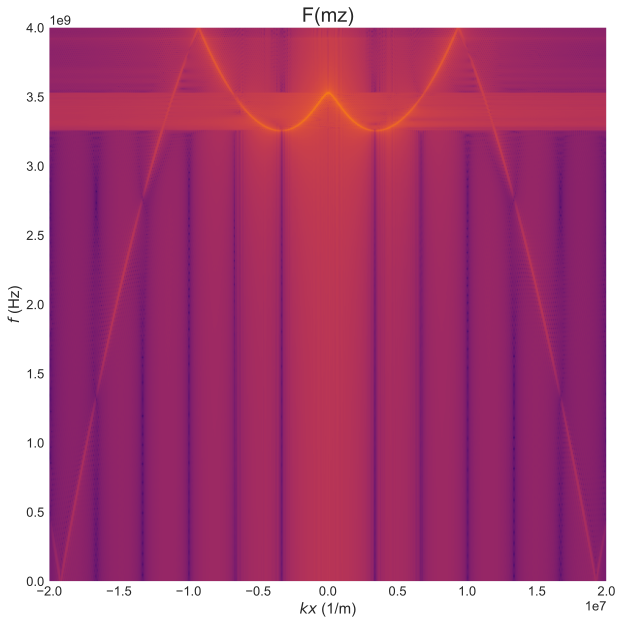

In [50]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x',"left")
plotDispersion(m_fft_y,xbounds,ybounds,'y',"left")
plotDispersion(m_fft_z,xbounds,ybounds,'z',"left")

## Transmittance
Analysis on the second  half of the sample

In [51]:
data = md.Data(sysName)
array = data[-1].to_xarray()
data_np = np.array(array)


mx = data_np[:, round((l/2+transverseFieldSize/2+buffer/2)/cx):round((l-band)/cx), 0, 0, 0]
my = data_np[:, round((l/2+transverseFieldSize/2+buffer/2)/cx):round((l-band)/cx), 0, 0, 1]
mz = data_np[:, round((l/2+transverseFieldSize/2+buffer/2)/cx):round((l-band)/cx), 0, 0, 2]

In [52]:
halfsize=round((l-band)/cx)-round((l/2+transverseFieldSize/2+buffer/2)/cx)
print(halfsize)
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, halfsize))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1,halfsize))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, halfsize))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

2872


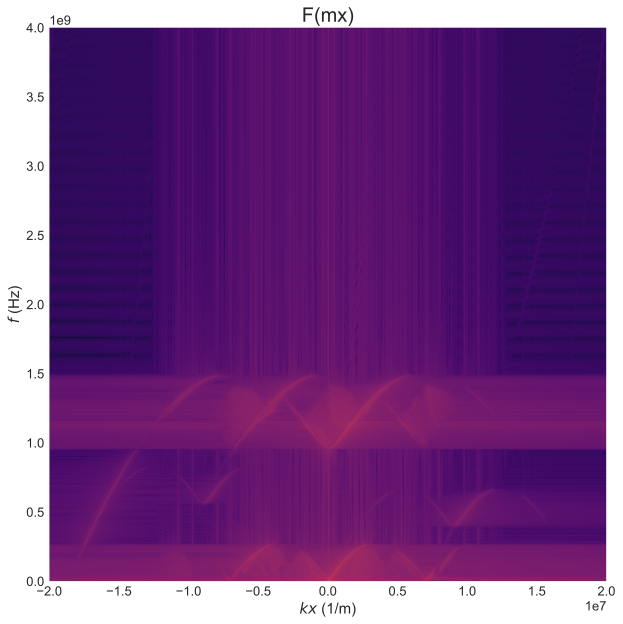

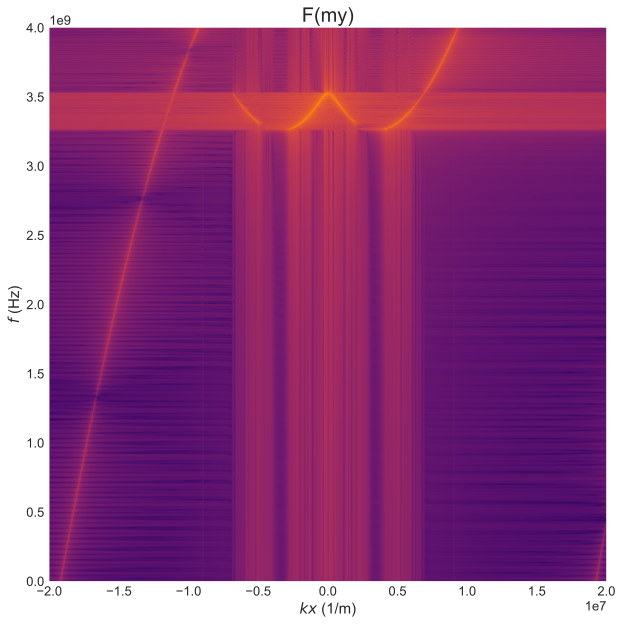

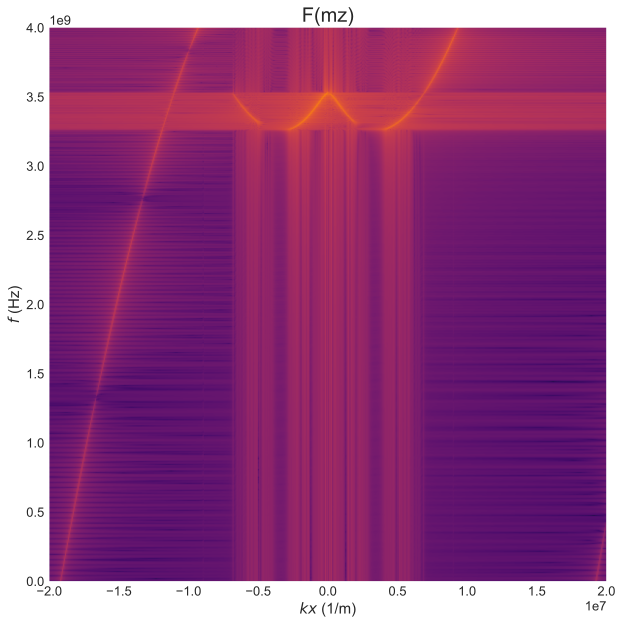

In [53]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x',"right")
plotDispersion(m_fft_y,xbounds,ybounds,'y',"right")
plotDispersion(m_fft_z,xbounds,ybounds,'z',"right")

## DISPERSION INSIDE THE TRANSVERSE FIELD
Analysis in the center region

In [54]:
data = md.Data(sysName)
array = data[-1].to_xarray()
data_np = np.array(array)


mx = data_np[:, round((l/2-transverseFieldSize/2)/cx):round((l/2+transverseFieldSize/2)/cx), 0, 0, 0]
my = data_np[:, round((l/2-transverseFieldSize/2)/cx):round((l/2+transverseFieldSize/2)/cx), 0, 0, 1]
mz = data_np[:, round((l/2-transverseFieldSize/2)/cx):round((l/2+transverseFieldSize/2)/cx), 0, 0, 2]

In [55]:
halfsize=round((transverseFieldSize/2)/cx)
print(halfsize)
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, halfsize))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1,halfsize))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, halfsize))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

25


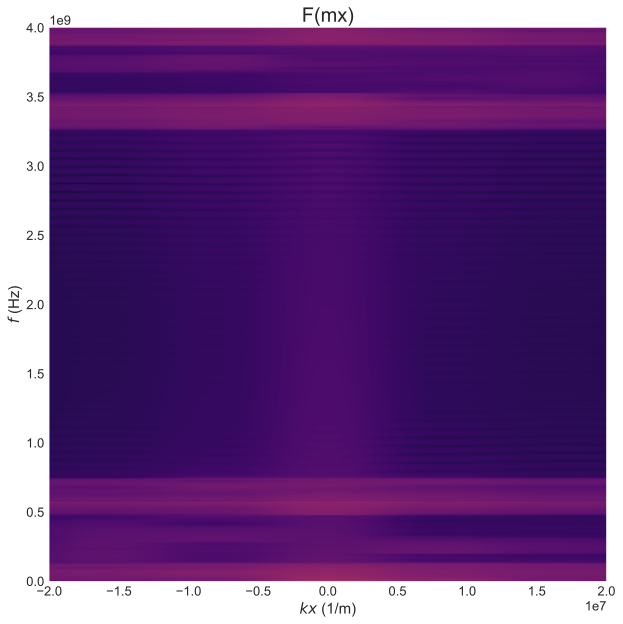

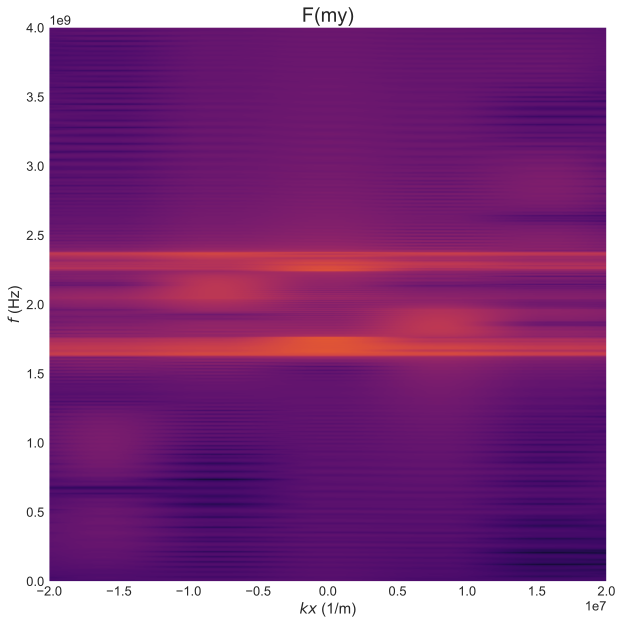

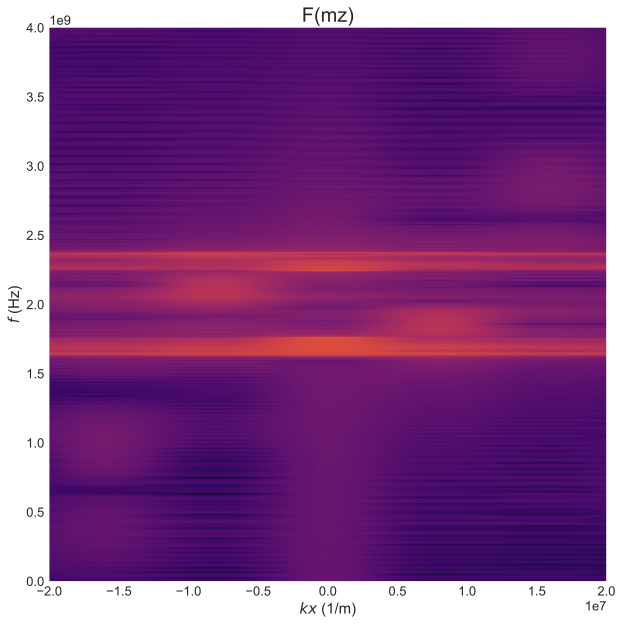

In [56]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x',"center")
plotDispersion(m_fft_y,xbounds,ybounds,'y',"center")
plotDispersion(m_fft_z,xbounds,ybounds,'z',"center")